# [Data Preprocessing in Python](https://www.datacamp.com/completed/statement-of-accomplishment/course/656c88c51ed37d0e879eb0e6ebe24b2cc171af19)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/datacamp/blob/main/notebooks/courses/data_preprocessing_in_python/notebook.ipynb)
[![Render nbviewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/datacamp/blob/main/notebooks/courses/data_preprocessing_in_python/notebook.ipynb)

**Contents**
- [Introduction](#Introduction)
- [Standardization](#Standardization)
- [Feature Engineering](#Feature-Engineering)
- [Feature Selection](#Feature-Selection)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

pd.set_option("display.width", 400)

hiking = pd.read_csv("hiking.csv")
volunteer = pd.read_csv("volunteer.csv")
wine = pd.read_csv("wine.csv")


## Introduction

In [2]:
# drop `Latitude` and `Longitude`
volunteer = volunteer.drop(["Latitude", "Longitude"], axis=1)

# drop rows with missing `category_desc`
volunteer = volunteer.dropna(subset=["category_desc"])

# print out the shape of the new dataset
print(volunteer.shape)


(617, 33)


In [3]:
# print head of `hits` col
print(volunteer["hits"].head())


1     22
2     62
3     14
4     31
5    135
Name: hits, dtype: int64


In [4]:
# `hits` is object type, convert to int
volunteer["hits"] = volunteer["hits"].astype("int")

# print dtypes
print(volunteer.dtypes)


opportunity_id          int64
content_id              int64
vol_requests            int64
event_time              int64
title                  object
hits                    int64
summary                object
is_priority            object
category_id           float64
category_desc          object
amsl                  float64
amsl_unit             float64
org_title              object
org_content_id          int64
addresses_count         int64
locality               object
region                 object
postalcode            float64
primary_loc           float64
display_url            object
recurrence_type        object
hours                   int64
created_date           object
last_modified_date     object
start_date_date        object
end_date_date          object
status                 object
Community Board       float64
Community Council     float64
Census Tract          float64
BIN                   float64
BBL                   float64
NTA                   float64
dtype: obj

In [5]:
# create a new DataFrame with all columns except `category_desc`
X = volunteer.drop("category_desc", axis=1)

# create a `category_desc` labels dataset
y = volunteer[["category_desc"]]

# use stratified sampling to split up the dataset according to `y`, ensuring reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=42,
)

# print the `category_desc` counts from `y_train`
print(y_train["category_desc"].value_counts())


category_desc
Strengthening Communities    230
Helping Neighbors in Need     89
Education                     69
Health                        39
Environment                   24
Emergency Preparedness        11
Name: count, dtype: int64


## Standardization

_Standardization_ is a preprocessing method used to transform continuous data to make it look normally distributed. In scikit-learn, this is often a necessary step because many models assume that the data is normally distributed.

It's important to note that standardization is applied to continuous, numerical data, not categorical.

### Linear Distances

There are a few scenarios in which you'd want to standardize your data. If you're working with a model that uses a linear distance metric or operates in a linear space like linear regression, k-nearest neighbors, or k-means clustering, then the model is assuming that the data is related in a linear fashion.

### High Variance

If the dataset features have a high variance, then the features with the largest variance will dominate the model.

### Different Scales

Modeling a dataset that contains continuous features on different scales is another scenario in which standardization is necessary. For example, if you are predicting house prices using last sale price and number of bedrooms, these features are on vastly different scales. To compare these features, they must be standardized to put them in the same linear space.

### Log Normalization

_Log normalization_ is a method for standardizing data with features that have high variance. Log normalization applies a logarithmic function to the values of the feature, which transforms them onto a scale that approximates normality. This [StackExchange discussion](https://stats.stackexchange.com/questions/27682/what-is-the-reason-why-we-use-natural-logarithm-ln-rather-than-log-to-base-10) helps explain why the natural log is preferred.

In statistical modeling, it is most common to use the _natural log_ to transform the data. The natural log is the power of $e$ that results in a given number $y$, where $e$ is the mathematical constant $2.71828$.

If $e^x = y$, then $\ln(y) = x$.

In Python, log normalization is easily done with NumPy's `log` method.

In [6]:
# print variance of `Proline`
print(wine["Proline"].var())


99166.71735542436


In [7]:
# apply log normalization to create new column `Proline_log`
wine["Proline_log"] = np.log(wine["Proline"])

# check variance
print(wine["Proline_log"].var())


0.17231366191842012


### Scaling

_Scaling_ is a method for standardizing features that are on different scales and a model that operates in a linear space. Scaling transforms the values of the features so they have a mean of zero and a variance of one.

In [8]:
# X is a dataframe of all columns except `Type`
# y is a series of `Type` labels
X = wine.drop("Type", axis=1)
y = wine["Type"]

# split training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=42,
)

# scale the training and test features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit the classifier to the training data
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

# score the model
print(knn.score(X_test_scaled, y_test))


0.9555555555555556


## Feature Engineering

_Feature engineering_ is the creation of new features from existing ones that can improve model performance by adding additional information to the dataset.

Manual feature engineering does require domain knowledge of your dataset, as it is dependent on the dataset's context.

### Encoding Categorical Variables

In [9]:
# encode `Accessible`
enc = LabelEncoder()
hiking["Accessible_enc"] = enc.fit_transform(hiking["Accessible"])

# compare
display(hiking[["Accessible", "Accessible_enc"]].head())


,Accessible,Accessible_enc
0,Y,1
1,N,0
2,N,0
3,N,0
4,N,0


In [10]:
# encode `category_desc` using one-hot
category_enc = pd.get_dummies(volunteer["category_desc"])
display(category_enc.head())


,Education,Emergency Preparedness,Environment,Health,Helping Neighbors in Need,Strengthening Communities
1,False,False,False,False,False,True
2,False,False,False,False,False,True
3,False,False,False,False,False,True
4,False,False,True,False,False,False
5,False,False,True,False,False,False


### Aggregating Numerical Features

In [11]:
# fmt: off
running_times_5k = pd.DataFrame({
  'name': ['Sue', 'Mark', 'Sean', 'Erin', 'Jenny', 'Russell'],
  'run1': [20.1, 16.5, 23.5, 21.7, 25.8, 30.9],
  'run2': [18.5, 17.1, 25.1, 21.1, 27.1, 29.6],
  'run3': [19.6, 16.9, 25.2, 20.9, 26.1, 31.4],
  'run4': [20.3, 17.6, 24.6, 22.1, 26.7, 30.4],
  'run5': [18.3, 17.3, 23.9, 22.2, 26.9, 29.9],
})
# fmt: on

# add `mean` column using `loc` specifically
running_times_5k["mean"] = running_times_5k.loc[:, "run1":"run5"].mean(axis=1)
display(running_times_5k.head())


,name,run1,run2,run3,run4,run5,mean
0,Sue,20.1,18.5,19.6,20.3,18.3,19.36
1,Mark,16.5,17.1,16.9,17.6,17.3,17.08
2,Sean,23.5,25.1,25.2,24.6,23.9,24.46
3,Erin,21.7,21.1,20.9,22.1,22.2,21.60
4,Jenny,25.8,27.1,26.1,26.7,26.9,26.52


### Extracting Datetime Components

In [12]:
# convert to date
volunteer["start_date_converted"] = pd.to_datetime(volunteer["start_date_date"])

# extract month
volunteer["start_date_month"] = volunteer["start_date_converted"].apply(lambda row: row.month)
display(volunteer[["start_date_month", "start_date_converted"]].head())


,start_date_month,start_date_converted
1,2,2011-02-01
2,1,2011-01-29
3,2,2011-02-14
4,2,2011-02-05
5,2,2011-02-12


### Extracting String Patterns

In [13]:
# extract numbers and decimals
def return_mileage(length):
    if not isinstance(length, str):
        return None

    # search text for matches
    mile = re.match(r"(\d+\.\d+)", length)

    # if match found, return the extracted value
    if mile is not None:
        return float(mile.group(0))


# apply the function to the `Length` column
hiking["Length_num"] = hiking["Length"].apply(lambda row: return_mileage(row))
display(hiking[["Length", "Length_num"]].head())


,Length,Length_num
0,0.8 miles,0.80
1,1.0 mile,1.00
2,0.75 miles,0.75
3,0.5 miles,0.50
4,0.5 miles,0.50


### Vectorizing Text

In [14]:
# create a text vectorizer
tfidf_vec = TfidfVectorizer()

# transform
volunteer = volunteer.dropna(subset=["title"])
title_text = volunteer["title"]
text_tfidf = tfidf_vec.fit_transform(title_text)

# split training and test sets
y = volunteer["category_desc"]
X_train, X_test, y_train, y_test = train_test_split(
    text_tfidf.toarray(),
    y,
    stratify=y,
    random_state=42,
)

# fit using Gaussian Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
print(nb.score(X_test, y_test))


0.5161290322580645


## Feature Selection

The goal of _feature selection_ is to improve model performance by eliminating features that are highly correlated, irrelevant, or redundant.

In [15]:
# drop
volunteer = volunteer.drop(
    ["category_desc", "created_date", "locality", "region", "vol_requests"], axis=1
)
display(volunteer.head())


,opportunity_id,content_id,event_time,title,hits,summary,is_priority,category_id,amsl,amsl_unit,...,end_date_date,status,Community Board,Community Council,Census Tract,BIN,BBL,NTA,start_date_converted,start_date_month
1,5008,37036,0,Web designer,22,Build a website for an Afghan business,NaN,1.0,NaN,NaN,...,February 01 2011,approved,NaN,NaN,NaN,NaN,NaN,NaN,2011-02-01,2
2,5016,37143,0,Urban Adventures - Ice Skating at Lasker Rink,62,Please join us and the students from Mott Hall...,NaN,1.0,NaN,NaN,...,January 29 2011,approved,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-29,1
3,5022,37237,0,Fight global hunger and support women farmers ...,14,The Oxfam Action Corps is a group of dedicated...,NaN,1.0,NaN,NaN,...,March 31 2012,approved,NaN,NaN,NaN,NaN,NaN,NaN,2011-02-14,2
4,5055,37425,0,Stop 'N' Swap,31,Stop 'N' Swap reduces NYC's waste by finding n...,NaN,4.0,NaN,NaN,...,February 05 2011,approved,NaN,NaN,NaN,NaN,NaN,NaN,2011-02-05,2
5,5056,37426,0,Queens Stop 'N' Swap,135,Stop 'N' Swap reduces NYC's waste by finding n...,NaN,4.0,NaN,NaN,...,February 12 2011,approved,NaN,NaN,NaN,NaN,NaN,NaN,2011-02-12,2


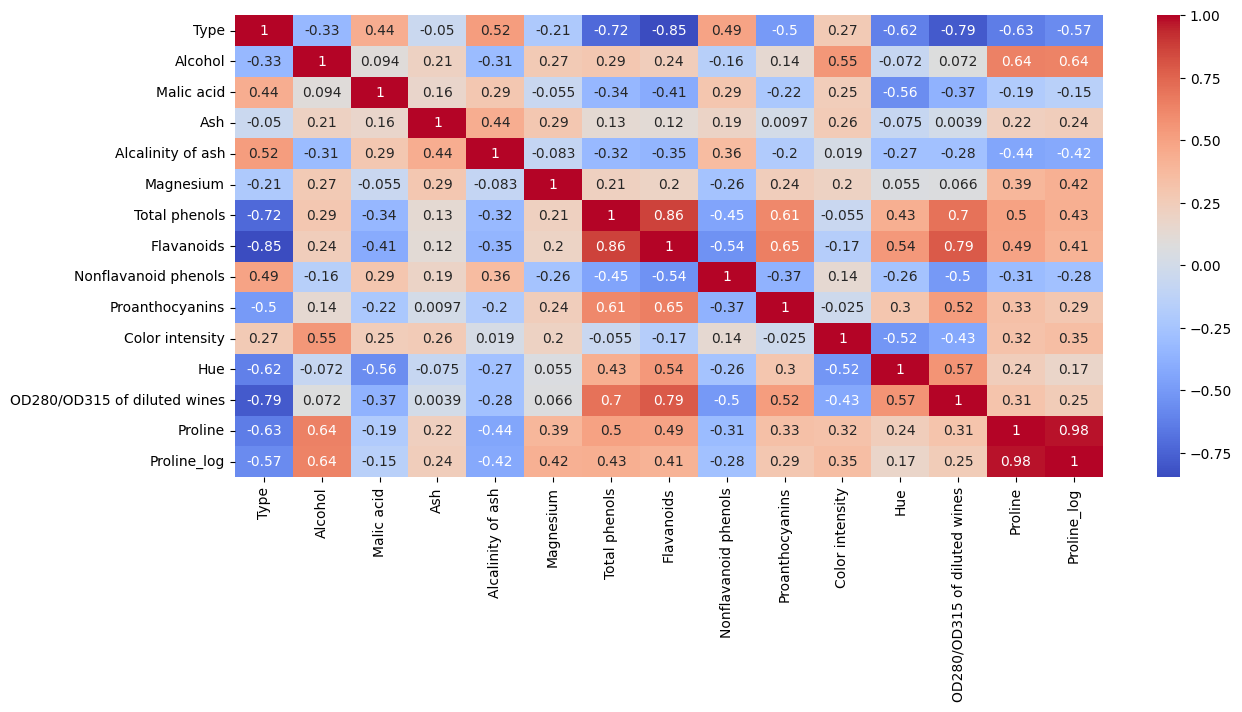

In [16]:
# wine correlations
corr = wine.corr()
plt.figure(figsize=(14, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()


In [17]:
# drop any columns with a correlation greater than 0.75
wine = wine.drop("Flavanoids", axis=1)
display(wine.head())


,Type,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Proline_log
0,1,14.23,1.71,2.43,15.6,127,2.80,0.28,2.29,5.64,1.04,3.92,1065,6.970730
1,1,13.20,1.78,2.14,11.2,100,2.65,0.26,1.28,4.38,1.05,3.40,1050,6.956545
2,1,13.16,2.36,2.67,18.6,101,2.80,0.30,2.81,5.68,1.03,3.17,1185,7.077498
3,1,14.37,1.95,2.50,16.8,113,3.85,0.24,2.18,7.80,0.86,3.45,1480,7.299797
4,1,13.24,2.59,2.87,21.0,118,2.80,0.39,1.82,4.32,1.04,2.93,735,6.599870


### Dimensionality Reduction

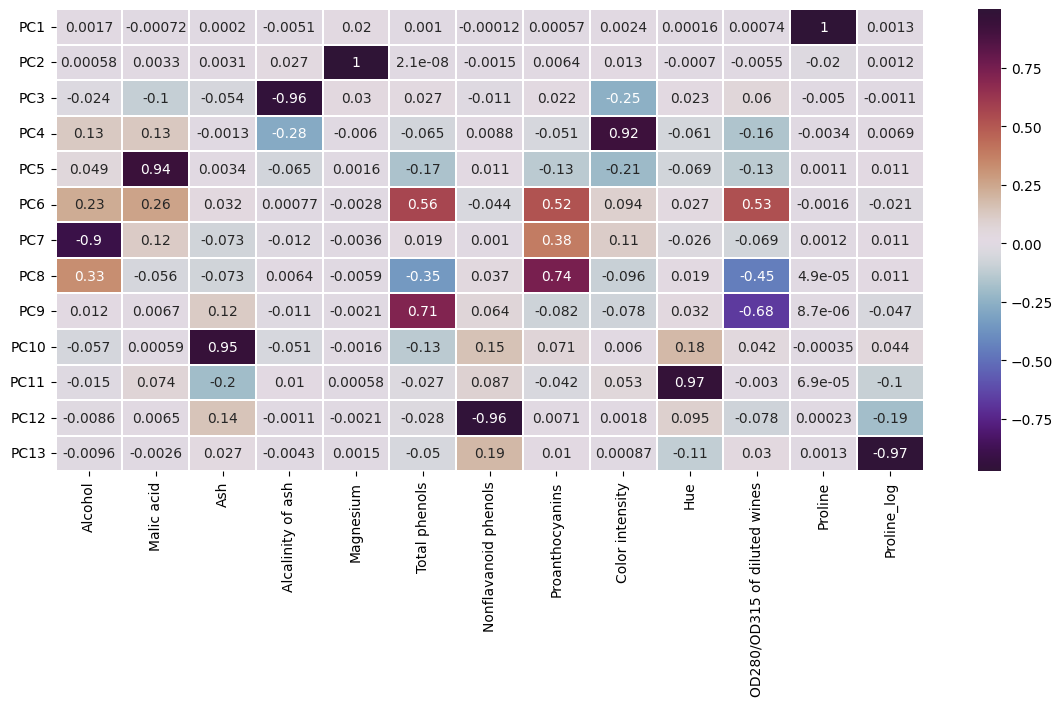

In [18]:
pca = PCA()

X = wine.drop("Type", axis=1)
y = wine["Type"]

# split training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=42,
)

# apply PCA to the X vector
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)

# plot a heatmap
data = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=[f"PC{i+1}" for i in range(len(pca.components_))],
)
plt.figure(figsize=(14, 6))
sns.heatmap(data, cmap="twilight_shifted", annot=True, linewidths=0.1)
plt.show()


In [19]:
# fit knn and score
knn = KNeighborsClassifier()
knn.fit(pca_X_train, y_train)
print(knn.score(pca_X_test, y_test))


0.7777777777777778
